In [1]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches
import matplotlib.pyplot as plt
import pandas as pd
import torch
import umap

from chronos import ChronosPipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

In [3]:
rng = np.random.default_rng()

In [4]:
def constant_ts(T, mu, sigma):
    return rng.normal(mu, sigma, T)

def trend_ts(T, t0, delta, sigma):
    return t0 + delta * np.arange(T) + rng.normal(0, sigma, T)

def sin_ts(T, c, A, omega, phi, sigma):
    return c + A * np.sin(omega * np.arange(T) + phi) + rng.normal(0, sigma, T)

def arma_ts(T, c, phi, theta, z_t_func, x_t_init=None, z_t_init=None):
    if x_t_init is None: x_t_init = np.full(len(phi), c / (1 - np.sum(phi)))
    assert len(phi) == len(x_t_init)

    if z_t_init is None: z_t_init = np.zeros(len(theta))
    assert len(theta) == len(z_t_init)

    x_t = np.zeros(len(x_t_init)+T)
    if len(x_t_init) > 0: x_t[:len(x_t_init)] = x_t_init

    z_t = np.zeros(len(z_t_init)+T)
    if len(z_t_init) > 0: z_t[:len(z_t_init)] = z_t_init
    z_t[len(z_t_init):] = z_t_func(T)

    for t in range(T):
        ar_p = np.sum([phi[i] * x_t[-T+t-i-1] for i in range(len(phi))])
        ma_q = np.sum([theta[i] * z_t[-T+t-i-1] for i in range(len(theta))])
        x_t[-T+t] = c + z_t[-T+t] + ar_p + ma_q

    return x_t[-T:]

def ar1_ts(T, c, phi, sigma):
    return arma_ts(T, c, [phi], [], lambda T: rng.normal(0.0, sigma, T))

def ma1_ts(T, c, theta, sigma):
    return arma_ts(T, c, [], [theta], lambda T: rng.normal(0.0, sigma, T))

def arma11_ts(T, c, phi, theta, sigma):
    return arma_ts(T, c, [phi], [theta], lambda T: rng.normal(0.0, sigma, T))

In [5]:
def gen_constant_ts(T):
    mu = rng.normal(0, 50)
    sigma = rng.exponential(2)
    return constant_ts(T, mu, sigma)

def gen_trend_ts(T):
    t0 = rng.normal(0, 50)
    delta = rng.normal(0, 0.3)
    sigma = rng.exponential(2)
    return trend_ts(T, t0, delta, sigma)

def gen_sin_ts(T):
    c = rng.normal(0, 50)
    A = rng.normal(0, 3)
    omega = rng.exponential(3)
    phi = rng.uniform(-np.pi, np.pi)
    sigma = rng.exponential(2)
    return sin_ts(T, c, A, omega, phi, sigma)

def gen_ar1_ts(T):
    phi = rng.uniform(0.01, 0.99)
    mu = rng.normal(0, 50)
    sigma = rng.exponential(2)
    c = mu * (1 - phi)
    return ar1_ts(T, c, phi, sigma)

def gen_ma1_ts(T):
    theta = rng.uniform(0.01, 0.99)
    c = rng.normal(0, 50)
    sigma = rng.exponential(2)
    return ar1_ts(T, c, theta, sigma)

def gen_arma11_ts(T):
    phi = rng.uniform(0.01, 0.99)
    theta = rng.uniform(0.01, 0.99)
    c = rng.normal(0, 50)
    sigma = rng.exponential(2)
    return arma11_ts(T, c, phi, theta, sigma)

In [6]:
N = 500
T = 512
T_MAX = 512

gen_funcs = {
    'constant': gen_constant_ts,
    'trend': gen_trend_ts,
    'sin': gen_sin_ts,
    'ar1': gen_ar1_ts,
    'ma1': gen_ma1_ts,
    'arma11': gen_arma11_ts
}

data = np.full((N, T_MAX), np.nan)
labels = np.random.choice(list(gen_funcs.keys()), N)

for i in range(N):
    data[i,-T:] = gen_funcs[labels[i]](T)

context = torch.tensor(data)

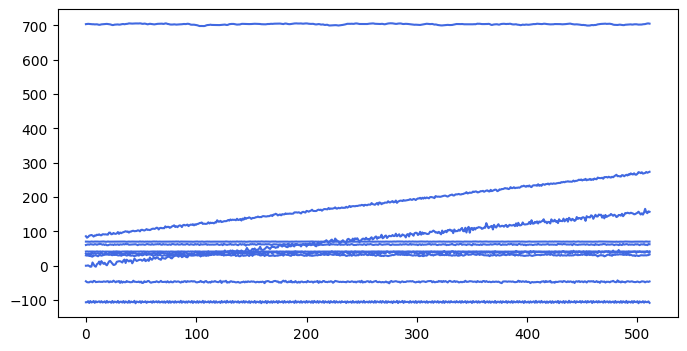

In [7]:
plt.figure(figsize=(8, 4))

for i in range(min(10, N)):
    plt.plot(data[i,:], color="royalblue", label="historical data")

In [8]:
embeddings_torch, tokenizer_state = pipeline.embed(context)
embeddings_np = embeddings_torch.float().numpy()
embeddings_mean = embeddings_np.mean(axis=1)

In [9]:
def plot_ts(data, embeddings, idx):
    pca = PCA(n_components=2).fit(embeddings[idx,:,:])
    components = pca.transform(embeddings[idx,:,:])

    plt.figure(figsize=(10, 6))
    plt.plot(data[idx,:], color="royalblue", label="historical data")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(components[:, 0], components[:, 1], alpha=0.7)
    
    for i in range(embeddings[idx,:,:].shape[0]):
        plt.annotate(str(i), (components[i, 0], components[i, 1]), fontsize=8)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

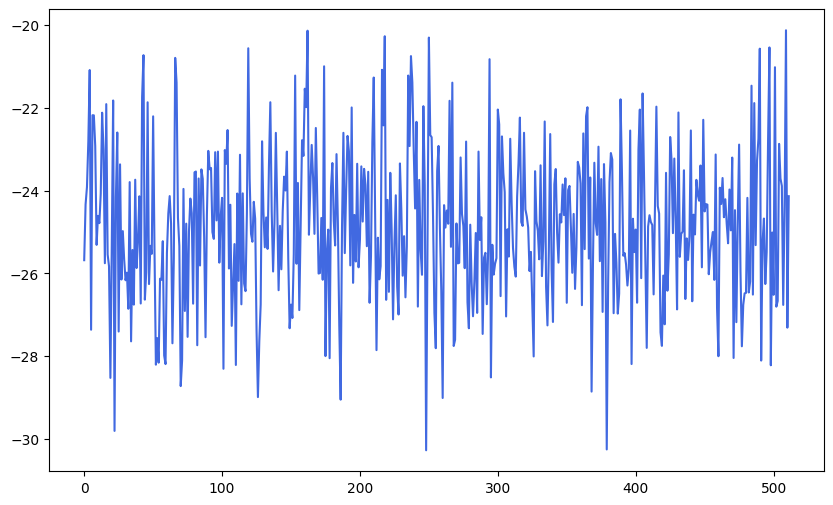

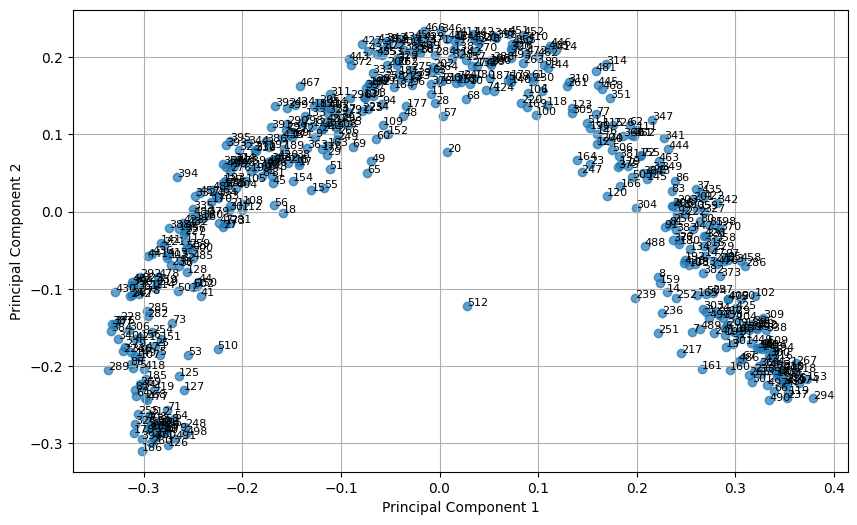

In [10]:
plot_ts(data, embeddings_np, 202)

In [11]:
def plot_components(components, labels, annotate=False):
    levels, categories = pd.factorize(labels)
    colors = [plt.cm.tab10(i) for i in levels]
    handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(components[:, 0], components[:, 1], c=colors)

    if annotate:
        for i in range(components.shape[0]):
            plt.annotate(str(i), (components[i, 0], components[i, 1]), fontsize=6)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=handles,  title='Color')
    plt.grid(True)
    plt.show()

### PCA

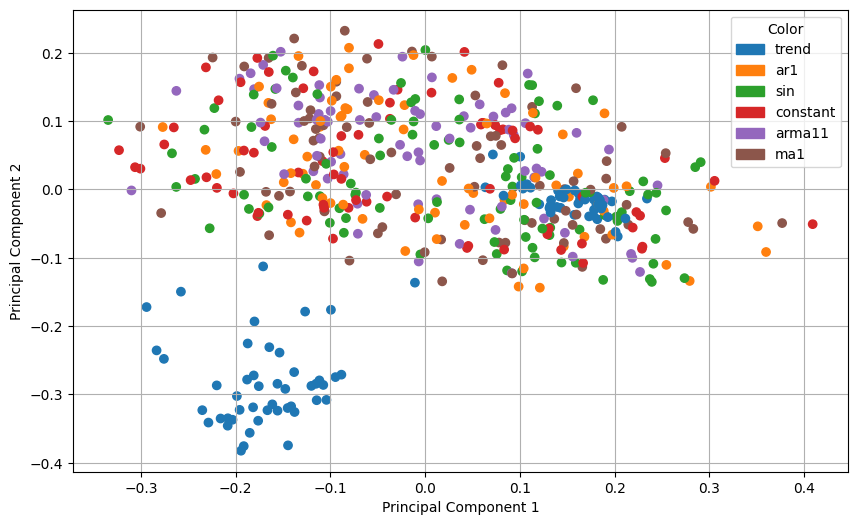

In [12]:
plot_components(PCA(n_components=2).fit_transform(embeddings_np[:,0,:]), labels)

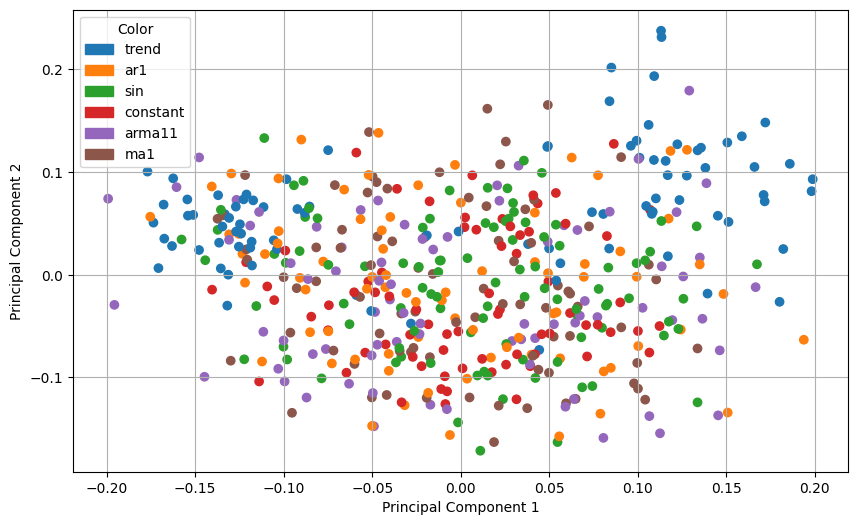

In [13]:
plot_components(PCA(n_components=2).fit_transform(embeddings_np[:,-1,:]), labels)

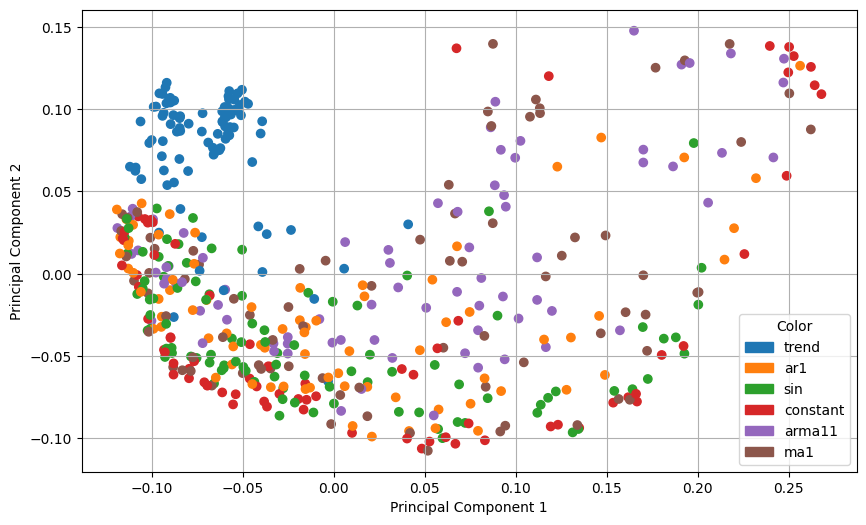

In [14]:
plot_components(PCA(n_components=2).fit_transform(embeddings_mean), labels)

### t-SNE

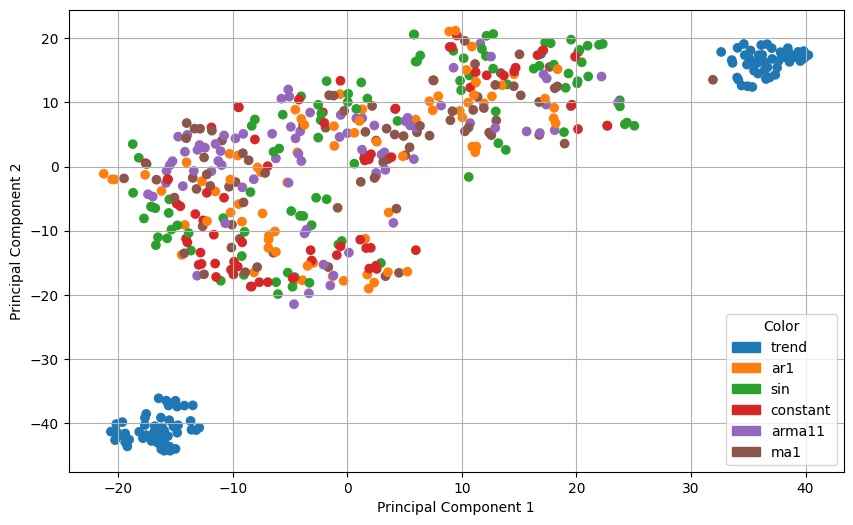

In [15]:
plot_components(TSNE(n_components=2).fit_transform(embeddings_np[:,0,:]), labels)

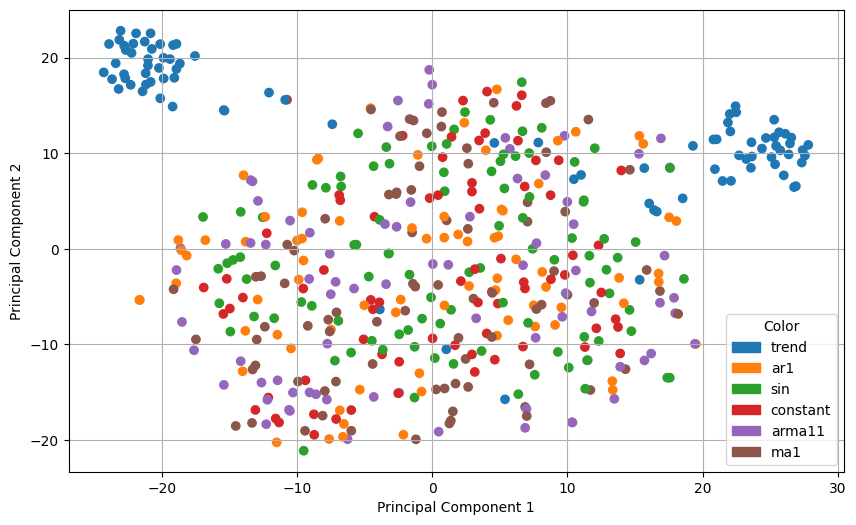

In [16]:
plot_components(TSNE(n_components=2).fit_transform(embeddings_np[:,-1,:]), labels)

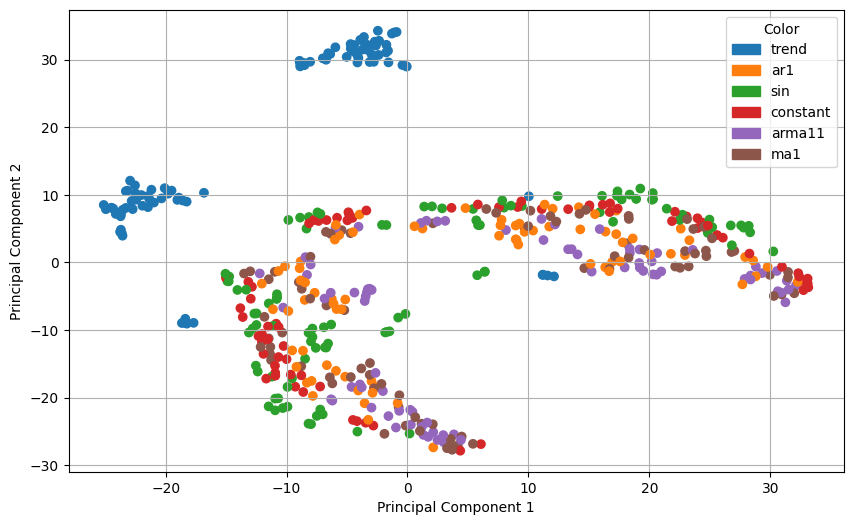

In [17]:
plot_components(TSNE(n_components=2).fit_transform(embeddings_mean), labels)

### UMAP

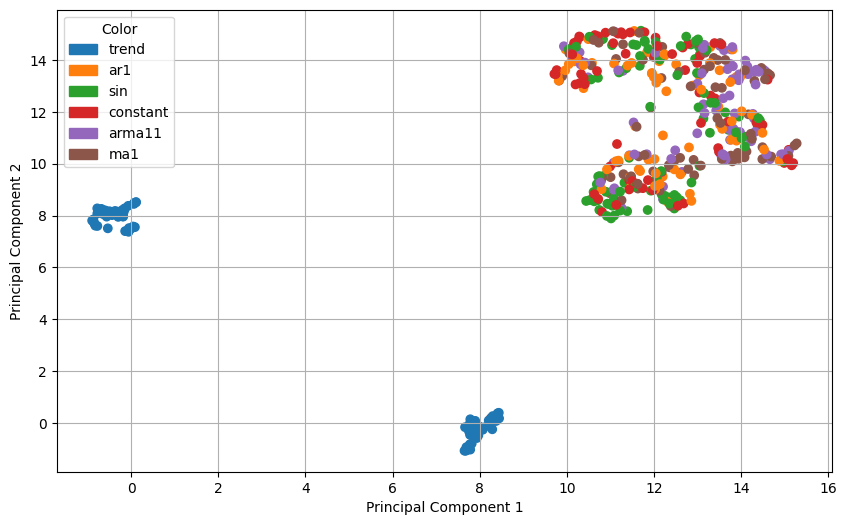

In [18]:
plot_components(umap.UMAP(n_components=2).fit_transform(embeddings_np[:,0,:]), labels)

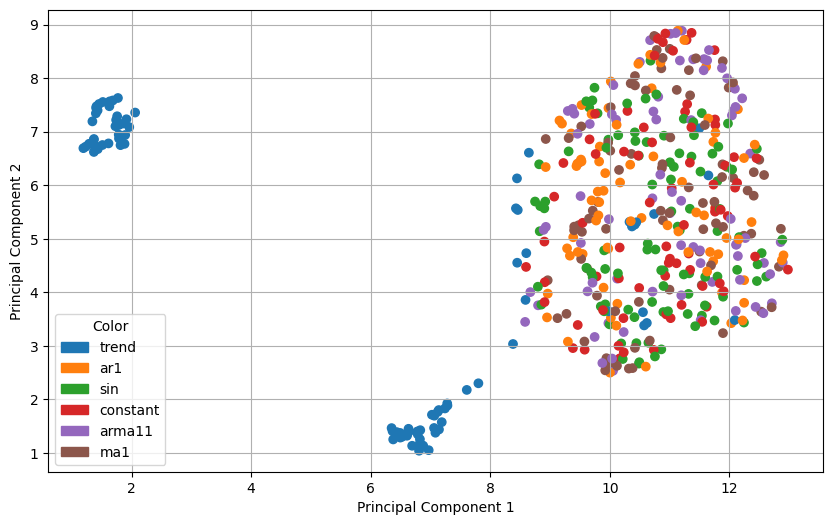

In [19]:
plot_components(umap.UMAP(n_components=2).fit_transform(embeddings_np[:,-1,:]), labels)

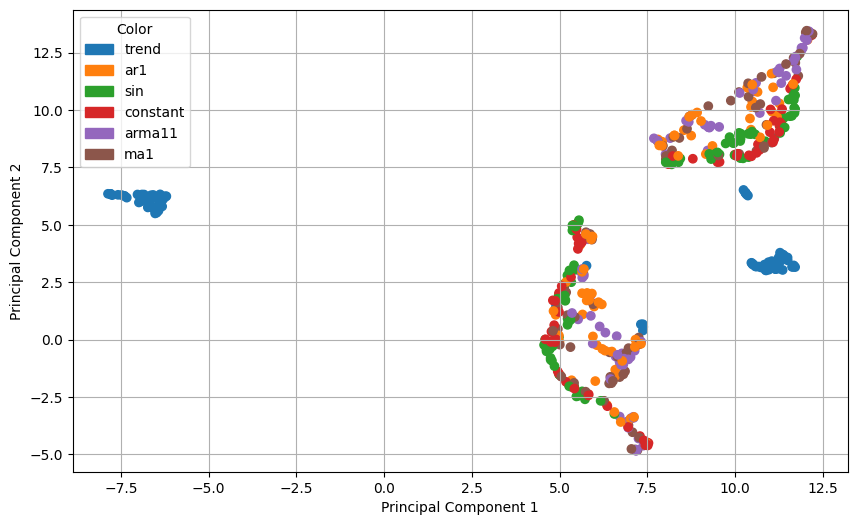

In [20]:
plot_components(umap.UMAP(n_components=2).fit_transform(embeddings_mean), labels)

## Regime change detection?

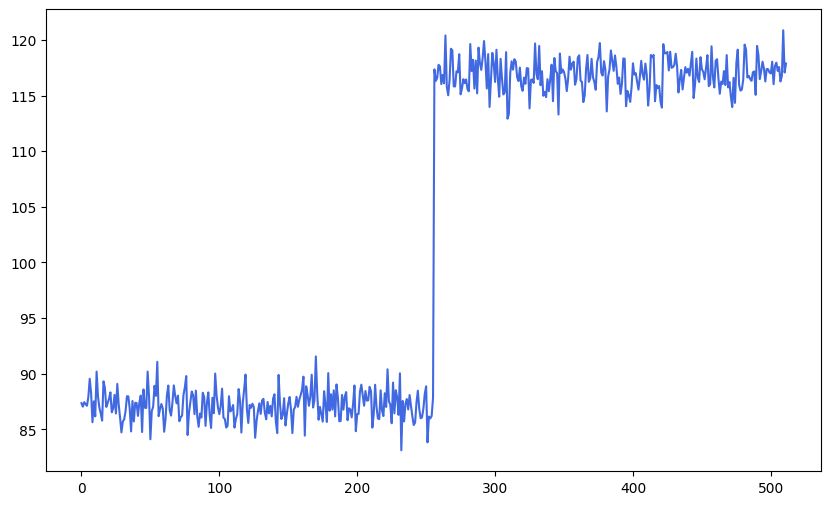

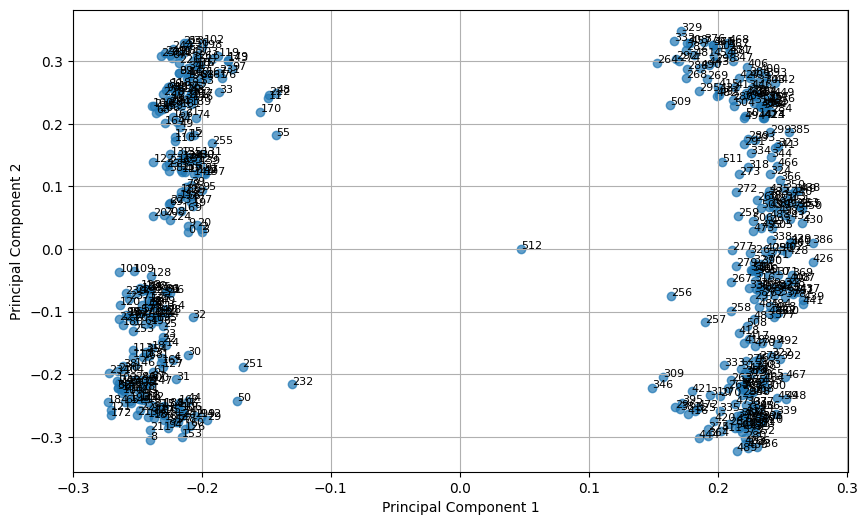

In [22]:
data2 = np.full((1, T_MAX), np.nan)
data2[0,-T:] = gen_constant_ts(T)
data2[0,int(T/2):] += 30

context2 = torch.tensor(data2)
embeddings2_torch, tokenizer_state = pipeline.embed(context2)
embeddings2_np = embeddings2_torch.float().numpy()
plot_ts(data2, embeddings2_np, 0)